In [ ]:
pip install opendatasets

In [ ]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tanayazore
Your Kaggle Key: ··········


100%|██████████| 2.70G/2.70G [00:20<00:00, 140MB/s]


In [ ]:
data_dir = '/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = '/content/new-plant-diseases-dataset/test'

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
# from keras.utils.np_utils import to_categorical
import numpy as np
import os,shutil

In [ ]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [ ]:
newpath = '/content/new-plant-diseases-dataset/test'
if not os.path.exists(newpath):
  os.makedirs(newpath)

x = os.listdir(train_dir)
for dir_names in x:
  p = os.listdir(os.path.join(train_dir,dir_names))
  if not os.path.exists(os.path.join(newpath, dir_names)):
    os.makedirs(os.path.join(newpath, dir_names))
  cnt = 0
  file_names = []
  for image_names in p:
    if cnt==250:
      break
    file_names.append(train_dir+'/'+dir_names+'/'+image_names)
    cnt += 1
  for f in file_names:
    shutil.move(f, os.path.join(newpath, dir_names))

In [ ]:
train_datagen = ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen = ImageDataGenerator()

train = train_datagen.flow_from_directory(directory=train_dir,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid = val_datagen.flow_from_directory(directory=valid_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')

test_datagen = ImageDataGenerator()

test = test_datagen.flow_from_directory(directory=test_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')


Found 60795 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 9533 images belonging to 39 classes.


In [ ]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=38)

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dropout(0.5)(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)

In [ ]:
model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [ ]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)


In [ ]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])


NameError: name 'model_main' is not defined

In [ ]:
model_main.fit(train,validation_data=valid,epochs=24,steps_per_epoch=200,verbose=1,callbacks=[es, lr])


NameError: name 'model_main' is not defined

In [ ]:
model_main.save("PLANT_DISEASE.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'model loss')

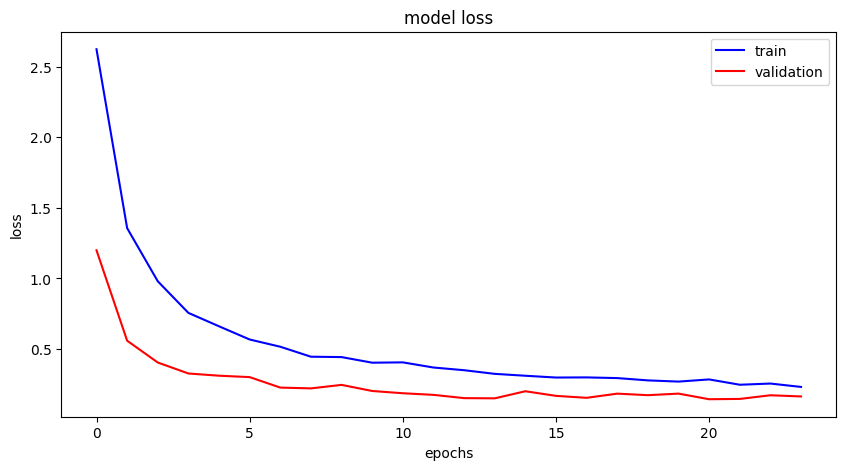

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

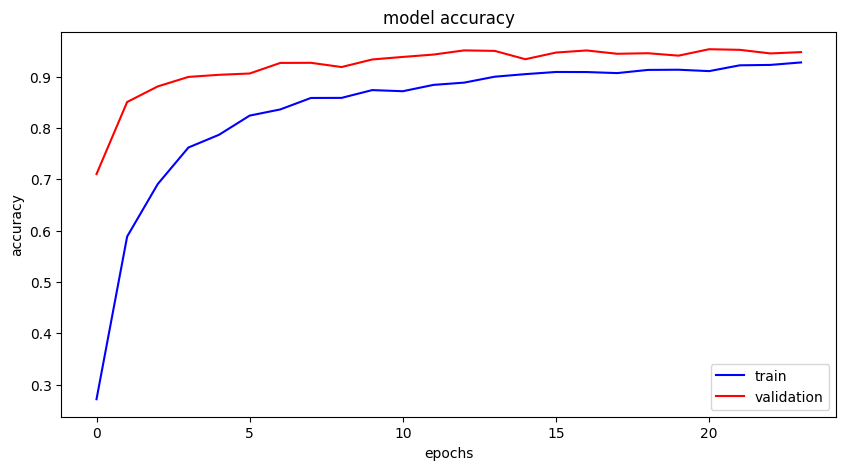

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [ ]:
loss, accuracy = model_main.evaluate(train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(valid, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))


1900/1900 [==============================] - 911s 480ms/step - loss: 0.1289 - accuracy: 0.9579
Train: accuracy = 0.957875  ;  loss = 0.128850
550/550 [==============================] - 60s 109ms/step - loss: 0.1641 - accuracy: 0.9476
Validation: accuracy = 0.947587  ;  loss = 0.164068


In [ ]:
# Assuming your model is already defined and compiled

# Create a test generator using flow_from_directory
test_generator = test_datagen.flow_from_directory(
    '/content/new-plant-diseases-dataset/test',
    target_size=(224, 224),  # Replace with your desired target size
    batch_size=16,
    class_mode='categorical'  # Adjust this based on your problem (binary, categorical, etc.)
)

# Evaluate on the test set using the generator
try:
    loss, accuracy = model_main.evaluate(test_generator, verbose=1)
    print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
except Exception as e:
    print("Error during evaluation on the test set:", str(e))
    # Print additional information for debugging
    print("Test set directory:", '/content/new-plant-diseases-dataset/test')  # Print the path to the test directory


Found 9533 images belonging to 39 classes.
Error during evaluation on the test set: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib

In [ ]:
model = load_model("/content/PLANT_DISEASE.h5")

In [ ]:
img = tensorflow.keras.utils.load_img(
    "/content/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Soybean___healthy/007734dd-ed98-4b69-b489-f7f98f18f065___RS_HL 2864.JPG",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model.predict(input_arr)

1/1 [==============================] - 0s 49ms/step


In [ ]:
probability_model = tensorflow.keras.Sequential([model,
                                         tensorflow.keras.layers.Softmax()])

In [ ]:
predict = probability_model.predict(input_arr)

1/1 [==============================] - 1s 1s/step


In [ ]:
predict[0]

array([0.02517842, 0.02517842, 0.02517842, 0.02517843, 0.02517843,
       0.02517842, 0.02517843, 0.02517842, 0.02517842, 0.02517842,
       0.02517842, 0.02517842, 0.02517842, 0.02517842, 0.02517842,
       0.02517842, 0.02517842, 0.02517842, 0.02517842, 0.02517944,
       0.02517842, 0.02517842, 0.02520289, 0.02517842, 0.0683728 ,
       0.02517842, 0.02517842, 0.02517842, 0.02517842, 0.02517842,
       0.02517842, 0.02517842, 0.02517842, 0.02517842, 0.02517842,
       0.02517842, 0.02517842, 0.02517842], dtype=float32)

In [ ]:
classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

In [ ]:
p = np.argmax(predict[0])
print(classes[p])

Soybean___healthy
